数据加载完成，共 1000 条记录。
类别分布：
Label
Alzheimer's Disease        200
Frontotemporal Dementia    200
Lewy Body Dementia         200
Parkinson's Disease        200
Vascular Dementia          200
Name: count, dtype: int64

词汇表大小: 7009

--- 10-Fold Cross-Validation Results ---
平均准确率: 0.5750 (+/- 0.0680)

--- Test Set Evaluation ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.72      0.65      0.68        40
Frontotemporal Dementia       0.58      0.70      0.64        40
     Lewy Body Dementia       0.52      0.55      0.54        40
    Parkinson's Disease       0.66      0.47      0.55        40
      Vascular Dementia       0.64      0.72      0.68        40

               accuracy                           0.62       200
              macro avg       0.63      0.62      0.62       200
           weighted avg       0.63      0.62      0.62       200



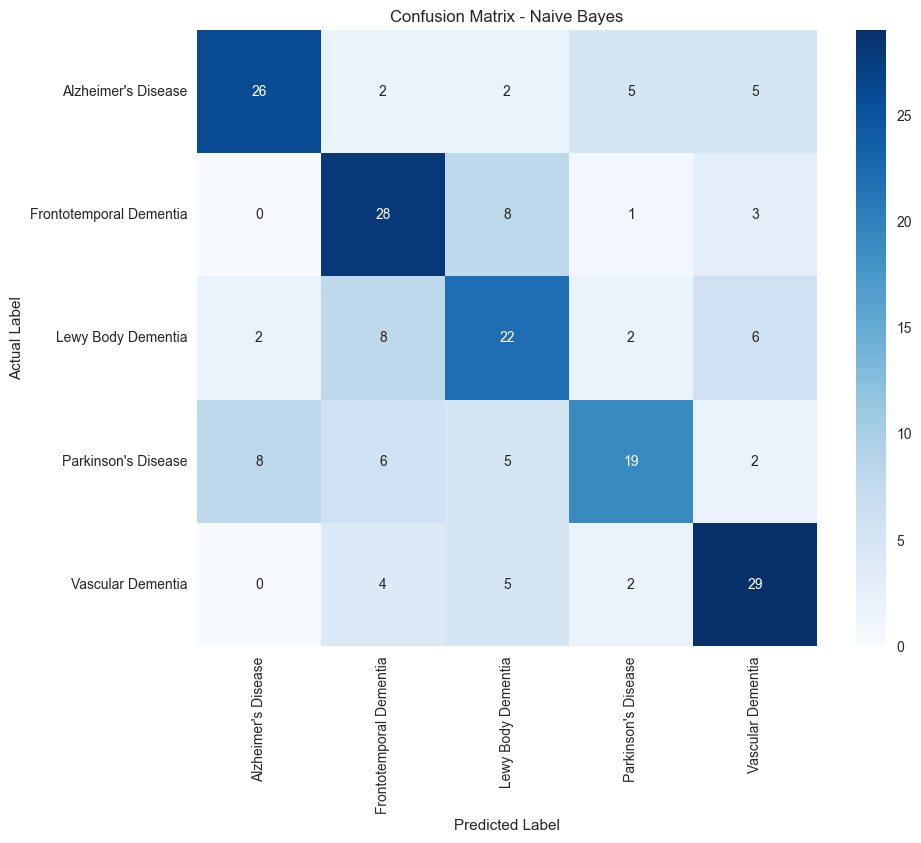

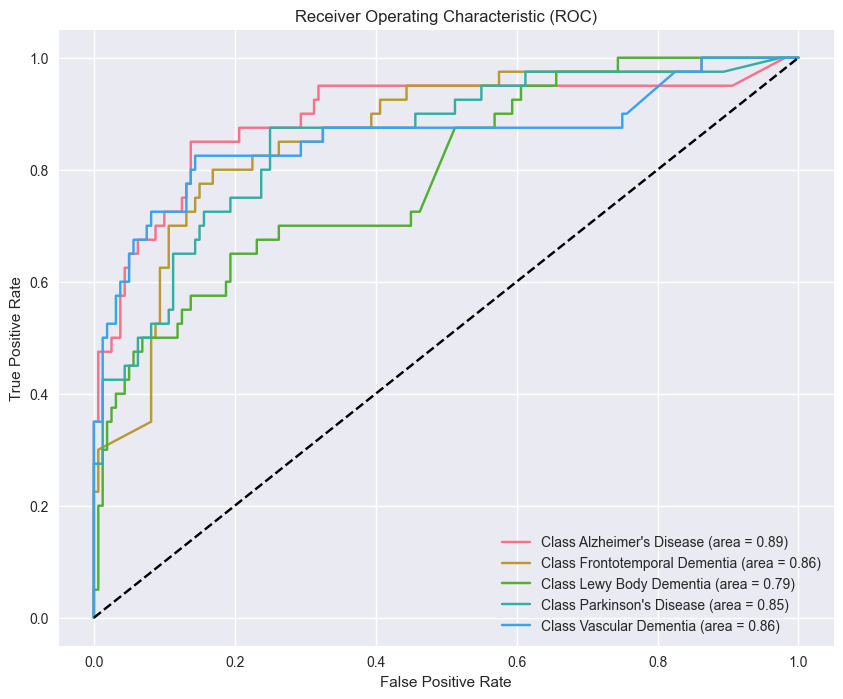

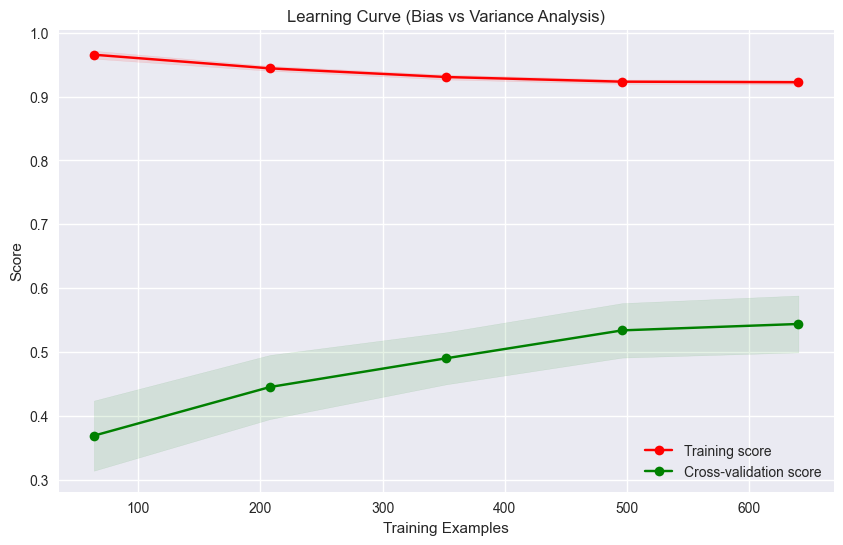


--- Error Analysis (Sample Misclassifications) ---
共发现 76 个错误分类样本。以下是前 3 个：
                  True_Label                Predicted  \
167      Alzheimer's Disease        Vascular Dementia   
237  Frontotemporal Dementia       Lewy Body Dementia   
892        Vascular Dementia  Frontotemporal Dementia   

                                                  Text  
167  population aging one common challenge current ...  
237  purpose evaluate diagnostic value combined sem...  
892  abstract available pad pad pad pad pad pad pad...  

--- Explainability: Top Keywords per Class ---
[Alzheimer's Disease]: ['patient', 'amyloid', 'method', 'cognitive', 'tau', 'model', 'brain', 'study', 'disease', 'pad']
[Frontotemporal Dementia]: ['tdp', 'mutation', 'variant', 'al', 'neurodegenerative', 'protein', 'study', 'patient', 'disease', 'pad']
[Lewy Body Dementia]: ['method', 'synuclein', 'clinical', 'cognitive', 'study', 'brain', 'body', 'patient', 'disease', 'pad']
[Parkinson's Disease]: ['based', 'mot

  0%|          | 0/1 [00:00<?, ?it/s]D:\Python\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.215e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

正在生成针对预测错误类别 'Vascular Dementia' 的 Waterfall 图...


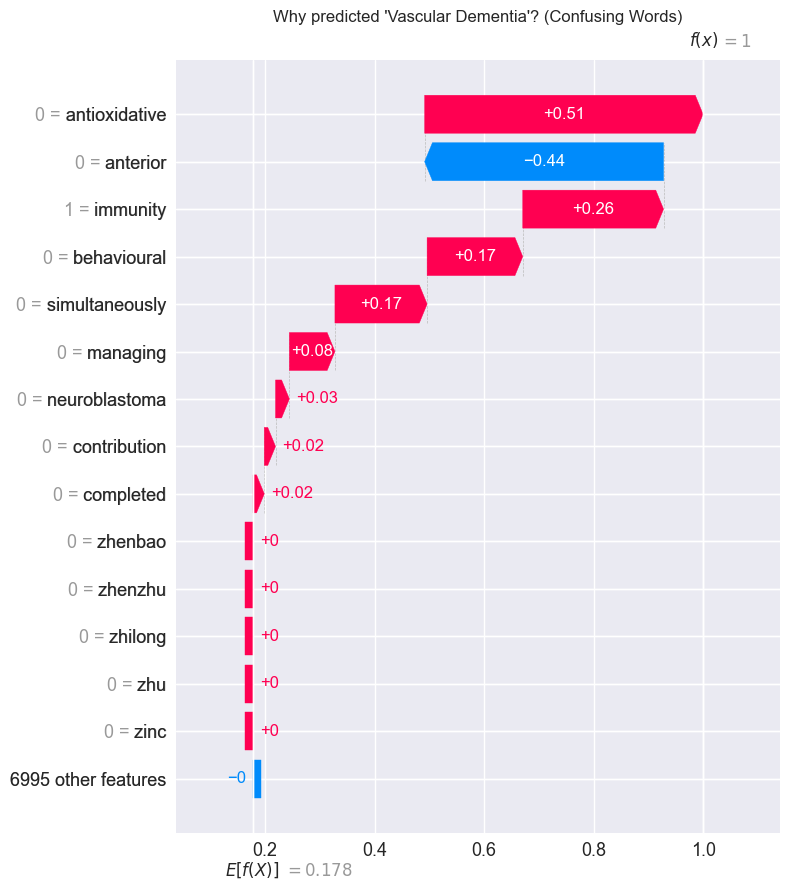


[图表解读指南]:
1. 红色条形 (Red bars): 这些词大大增加了被预测为错误类别的概率 (即混淆词)。
2. 蓝色条形 (Blue bars): 这些词试图把预测拉回正确方向，但失败了。
3. 灰色数字 (Grey numbers): 单词在文中的出现次数 (0表示未出现)。


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据加载与准备
# ==========================================
# 读取CSV文件
df = pd.read_csv('../cleaned_data.csv')

# 确保文本内容没有空值
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

print(f"数据加载完成，共 {len(df)} 条记录。")
print("类别分布：")
print(df['Label'].value_counts())

# ==========================================
# 2. 特征工程 (Bag of Words) & 数据切分
# ==========================================
# 划分训练集和测试集 (80% 训练, 20% 测试)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# 使用 CountVectorizer (BoW 特征)
# 这里使用 unigram (1,1)，如果需要更复杂的特征可以改为 (1,2)
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_bow = vectorizer.fit_transform(X_train_raw)
X_test_bow = vectorizer.transform(X_test_raw)

print(f"\n词汇表大小: {len(vectorizer.get_feature_names_out())}")

# ==========================================
# 3. 模型训练 (Naïve Bayes) & 10折交叉验证
# ==========================================
nb_classifier = MultinomialNB()

# 执行 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_classifier, X_train_bow, y_train, cv=cv, scoring='accuracy')

print("\n--- 10-Fold Cross-Validation Results ---")
print(f"平均准确率: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 在全量训练集上训练模型
nb_classifier.fit(X_train_bow, y_train)

# ==========================================
# 4. 评估与可视化 (Evaluation & Viz)
# ==========================================
y_pred = nb_classifier.predict(X_test_bow)

print("\n--- Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

# [图表 1] 混淆矩阵 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [图表 2] ROC 曲线 (多分类处理)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = nb_classifier.predict_proba(X_test_bow)

plt.figure(figsize=(10, 8))
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ==========================================
# 5. 偏差与方差分析 (Bias & Variability) - 学习曲线
# ==========================================
train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB(), X_train_bow, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Bias vs Variance Analysis)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# ==========================================
# 6. 错误分析 (Error Analysis)
# ==========================================
print("\n--- Error Analysis (Sample Misclassifications) ---")
results = pd.DataFrame({'Text': X_test_raw, 'True_Label': y_test, 'Predicted': y_pred})
errors = results[results['True_Label'] != results['Predicted']]

if not errors.empty:
    print(f"共发现 {len(errors)} 个错误分类样本。以下是前 3 个：")
    print(errors.head(3)[['True_Label', 'Predicted', 'Text']])

    # 获取最具辨识度的关键词 (Explainability)
    print("\n--- Explainability: Top Keywords per Class ---")
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(nb_classifier.classes_):
        top10_indices = np.argsort(nb_classifier.feature_log_prob_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]
        print(f"[{class_label}]: {top10_words}")

# ==========================================
# 7. Massage the Data (Control Hardship)
# 通过截断文本长度来降低准确率，模拟增加预测难度
# ==========================================
print("\n--- Massage Data Experiment (Truncation) ---")
def massage_data_trunc(text, max_words=20):
    words = text.split()
    return ' '.join(words[:max_words])

# 创建截断后的数据集 (每篇文档仅保留前 20 个词)
df['Massaged_Content'] = df['Cleaned_Content'].apply(lambda x: massage_data_trunc(x, max_words=20))

# 重新训练和评估
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    df['Massaged_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)
vec_m = CountVectorizer()
X_train_m_bow = vec_m.fit_transform(X_train_m)
X_test_m_bow = vec_m.transform(X_test_m)

nb_m = MultinomialNB()
nb_m.fit(X_train_m_bow, y_train_m)
acc_m = accuracy_score(y_test_m, nb_m.predict(X_test_m_bow))
print(f"原始准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"截断数据后准确率 (20 words): {acc_m:.4f}")
print("结论: 通过大幅减少可用特征(单词)，成功增加了模型的预测难度。")
# ==========================================
# 8. SHAP 可解释性分析 (混淆词识别)
# ==========================================
import shap

print("\n--- Starting SHAP Explainability Analysis ---")

# 步骤 A: 找出预测错误的样本 (复用之前的 errors DataFrame)
# 如果之前的 errors 被覆盖了，这里重新生成一下
results = pd.DataFrame({'Text': X_test_raw, 'True_Label': y_test, 'Predicted': y_pred})
errors = results[results['True_Label'] != results['Predicted']]

print(f"共发现 {len(errors)} 个错误分类样本。")

if len(errors) > 0:
    # 步骤 B: 选择一个具体的错误案例
    # 这里我们取第一个错误样本 (iloc[0])，您也可以换成其他索引
    error_idx = errors.index[0]

    # 找到该样本在测试集矩阵中的位置索引
    loc_idx = list(X_test_raw.index).index(error_idx)

    sample_text = errors.loc[error_idx, 'Text']
    true_label = errors.loc[error_idx, 'True_Label']
    pred_label = errors.loc[error_idx, 'Predicted']

    print(f"\n[分析样本 ID: {error_idx}]")
    print(f"真实标签: {true_label}")
    print(f"预测标签: {pred_label} (模型犯错了!)")

    # ---------------------------------------------------------
    # 步骤 C: 初始化 SHAP KernelExplainer
    # ---------------------------------------------------------
    print("\n正在初始化 SHAP KernelExplainer (这可能需要一两分钟)...")

    # KernelExplainer 需要背景数据来估算"缺失特征"的影响。
    # 为了速度，我们只取训练集的前 50 个样本作为背景摘要。
    # 注意: MultinomialNB 的 predict_proba 接受 sparse 矩阵，但 SHAP 处理 dense 更稳健
    background_data = X_train_bow[:50].toarray()

    # 定义预测包装函数: 输入 dense array -> 输出概率
    def predict_fn(data):
        # 将 dense 数据转回 sparse 可能会更高效，但对于小样本 dense 也行
        return nb_classifier.predict_proba(data)

    explainer = shap.KernelExplainer(predict_fn, background_data)

    # 获取目标样本的特征向量 (转为 dense)
    target_sample = X_test_bow[loc_idx].toarray()

    # ---------------------------------------------------------
    # 步骤 D: 计算 SHAP 值
    # ---------------------------------------------------------
    print("正在计算 SHAP 值 (nsamples=100)...")
    # nsamples 控制估算精度，值越大越准但越慢
    shap_values = explainer.shap_values(target_sample, nsamples=100)

    # ---------------------------------------------------------
    # 步骤 E: 智能处理 SHAP Values 并绘图
    # ---------------------------------------------------------
    print(f"正在生成针对预测错误类别 '{pred_label}' 的 Waterfall 图...")

    # 1. 获取预测类别在模型中的索引
    pred_class_idx = list(nb_classifier.classes_).index(pred_label)

    # 2. 智能提取数据 (兼容 List 和 Array 两种 SHAP 返回格式)
    sv_to_plot = None
    base_val_to_plot = None

    if isinstance(shap_values, list):
        # 情况 A: List 格式 [class][sample, feature]
        # 取出对应类别的 SHAP 值矩阵，再取第 0 个样本
        sv_to_plot = shap_values[pred_class_idx][0]
        base_val_to_plot = explainer.expected_value[pred_class_idx]

    elif isinstance(shap_values, np.ndarray):
        # 情况 B: Array 格式 (sample, feature, class) 或 (1, features)
        if len(shap_values.shape) == 3:
            sv_to_plot = shap_values[0, :, pred_class_idx]
        else:
            # 二分类情况，通常只返回正类的 SHAP 值
            sv_to_plot = shap_values[0]

        # 处理 expected_value
        if hasattr(explainer.expected_value, '__iter__'):
            base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
            base_val_to_plot = explainer.expected_value

    # 3. 绘制 Waterfall Plot
    if sv_to_plot is not None:
        explanation = shap.Explanation(
            values=sv_to_plot,
            base_values=base_val_to_plot,
            data=target_sample[0],
            feature_names=vectorizer.get_feature_names_out()
        )

        plt.figure(figsize=(10, 6))
        shap.plots.waterfall(explanation, max_display=15, show=False)
        plt.title(f"Why predicted '{pred_label}'? (Confusing Words)")
        plt.tight_layout()
        plt.show()

        print("\n[图表解读指南]:")
        print("1. 红色条形 (Red bars): 这些词大大增加了被预测为错误类别的概率 (即混淆词)。")
        print("2. 蓝色条形 (Blue bars): 这些词试图把预测拉回正确方向，但失败了。")
        print("3. 灰色数字 (Grey numbers): 单词在文中的出现次数 (0表示未出现)。")
    else:
        print("Error: 无法解析 SHAP values 的数据结构。")

else:
    print("没有错误样本可分析。")